# Redshift Space Distortions

This tutorial follows on from the [coeval cube](coeval_cubes) and [lightcone](lightcones) tutorials, and provides an introduction to apply the effects of redshift space distortions (RSDs) with ``21cmFAST``. If you are new to ``21cmFAST`` you should go through the coeval cube and lightcone tutorials first.

According to [Mao et al. 2012](https://arxiv.org/pdf/1104.2094), there are two types of distortions due to peculiar velocity along the line-of-sight (LOS) vecotr $\mathbf n$.
1. **Brightness temperature distortion in real-space.** This effect modifies the 21-cm optical depth due to the velocity gradient of HI atoms,
\begin{equation*}
\tau_{21}\propto\left|1+\frac{1}{H}\frac{d\left(\mathbf n\cdot \mathbf v\right)}{d\left(\mathbf n\cdot \mathbf x\right)}\right|^{-1}.
\end{equation*}
 This velocity gradient arises simply because we measure the optical depth from an expanding medium.
2. **Apparent location distortion in redshift-space.** This is the well known RSD effect: sources appear to be closer/further away from us due to their peculiar velocity. In our case, the sources are the HI atoms!

The above two effects can be accounted when running lightcones in `21cmFAST`, regardless if they are rectilinear or angular. The first effect is taken into account by setting `INCLUDE_DVDR_IN_TAU21=True`, while the second effect can be taken into account by setting `APPLY_RSDS=True`.

While we stress that the first effect (that is controlled by the `INCLUDE_DVDR_IN_TAU21` flag) has nothing to with redshift space, below we collectively refer to it together with the second effect as "RSDs".

In [1]:
from tempfile import mkdtemp

import matplotlib.pyplot as plt
import numpy as np

import py21cmfast as p21c
from py21cmfast import plotting

#%matplotlib inline

In [2]:
cache = p21c.OutputCache(mkdtemp())

## Redshift Space Distortions in Rectilinear Lightcone

Let's set up a standard rectilinear lightcone subclass.

In [3]:
inputs = p21c.InputParameters.from_template(
        'simple',
        node_redshifts=p21c.wrapper.inputs.get_logspaced_redshifts(
            min_redshift=7.0,
            z_step_factor=1.1,
            max_redshift=12.0,
        ),
        random_seed=1234,
    ).evolve_input_structs(HII_DIM=64, BOX_LEN=128, N_THREADS = 4)

In [4]:
lcn = p21c.RectilinearLightconer.between_redshifts(
    min_redshift=inputs.node_redshifts[-1]+0.5,
    max_redshift=inputs.node_redshifts[0]-0.5,
    quantities=("brightness_temp","density"),
    resolution=inputs.simulation_options.cell_size,
)

Note that we defined the boundaries of our lightconer to be slightly shorter than the boundaries of `node_redshifts`. This is required when we  `APPLY_RSDS`, as "mass" outside the lightcone shifts to its interior due to the RSD effect. `21cmFASTv4` accounts for this effect by constructing a bigger "ghost" lightconer that is used throughout the simulation. Once the RSD calculation finishes, the returned lightcone object has the same size as the user's input lightconer.

Note also that the implementation of RSDs on lightcones in `21cmFASTv4` has been updated. In `21cmFASTv3` both RSD effects were implemented on the coeval box, while the lightcone was later constructed from interpolating the coeval boxes. In contrast, in `21cmFASTv4` the coeval boxes are always computed without the effect of RSDs, as these effects are applied later on the lightcone once its construction is complete. This was done to highlight the fact that RSDs act along the LOS, and since coeval boxes have no preferred direction, the lightcone is the more appropriate object to consider here. Nevertheless, `21cmFASTv4` still allows the application of RSDs on coeval boxes (even though it is less consistent), as we show later in this tutorial.

We run first a lightcone without any RSD effect.

In [5]:
idx, z, coeval, lightcone = p21c.run_lightcone(
    lightconer=lcn,
    global_quantities=("brightness_temp",),
    inputs=inputs.evolve_input_structs(INCLUDE_DVDR_IN_TAU21=False, APPLY_RSDS=False),
    cache=cache,
    progressbar=True
)

Evolving Astrophysics: 100%|██████████| 7/7 [00:04<00:00,  1.49redshift/s]


Now we run two more lightcones with the RSD effects.

In [6]:
idx, z, coeval, lightcone_include_dvdr_in_tau21 = p21c.run_lightcone(
    lightconer=lcn,
    global_quantities=("brightness_temp",),
    inputs=inputs.evolve_input_structs(INCLUDE_DVDR_IN_TAU21=True, APPLY_RSDS=False),
    cache=cache,
    progressbar=True
)

Evolving Astrophysics: 100%|██████████| 7/7 [00:05<00:00,  1.21redshift/s]


In [7]:
idx, z, coeval, lightcone_apply_rsds = p21c.run_lightcone(
    lightconer=lcn,
    global_quantities=("brightness_temp",),
    inputs=inputs.evolve_input_structs(INCLUDE_DVDR_IN_TAU21=True, APPLY_RSDS=True),
    cache=cache,
    progressbar=True
)

Evolving Astrophysics: 100%|██████████| 7/7 [00:21<00:00,  3.05s/redshift]


Before making any comparison plots, let us verify that the boundaries of the lightcone from the last simulation matches the boundaries of our input lightconer, even though the inclusion of the RSDs required a larger "ghost" lightcone to consider.

In [8]:
np.all(lightcone_apply_rsds.lightcone_distances == lcn.lc_distances)

np.True_

Now let's compare all the three lightcones!

We begin by showing the front face of them. Note that when setting `INCLUDE_DVDR_TAU21=True`, then the lightcone box stored in `brightness_temp` is modified to include the effect of velocity gradient. If `APPLY_RSDS=True`, the output lightcone contains a new quantity named `brightness_temp_with_rsds`. As the name suggests, this quantity accounts for the effects of `APPLY_RSDS` on the brightness temperature field such that this quantity is now given in redshift space. In real space, the brightness temperature field is still saved in `brightness_temp`.

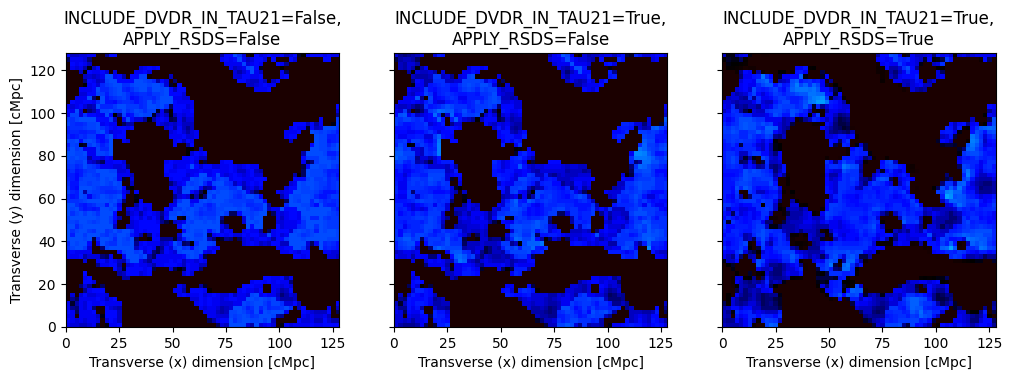

In [9]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 16))
kw = {
    "origin": "lower",
    "extent": (0, inputs.simulation_options.BOX_LEN, 0, inputs.simulation_options.BOX_LEN),
    "cmap": "EoR",
    "vmin": -150,
    "vmax": 30,
}

ax[0].imshow(lightcone.lightcones["brightness_temp"][:, :, 0], **kw)
ax[0].set_title("INCLUDE_DVDR_IN_TAU21=False,\nAPPLY_RSDS=False")
ax[1].imshow(lightcone_include_dvdr_in_tau21.lightcones["brightness_temp"][:, :, 0], **kw)
ax[1].set_title("INCLUDE_DVDR_IN_TAU21=True,\nAPPLY_RSDS=False")
ax[2].imshow(lightcone_apply_rsds.lightcones["brightness_temp_with_rsds"][:, :, 0], **kw)
ax[2].set_title("INCLUDE_DVDR_IN_TAU21=True,\nAPPLY_RSDS=True")

ax[0].set_xlabel("Transverse (x) dimension [cMpc]")
ax[1].set_xlabel("Transverse (x) dimension [cMpc]")
ax[2].set_xlabel("Transverse (x) dimension [cMpc]")
ax[0].set_ylabel("Transverse (y) dimension [cMpc]");

Both RSD effects modify the brightness temperature map. In addition, variations in the morphology of the reionized regions can be observed.

We can also inspect how RSDs modifies the 21-cm signal as a function of redshift.

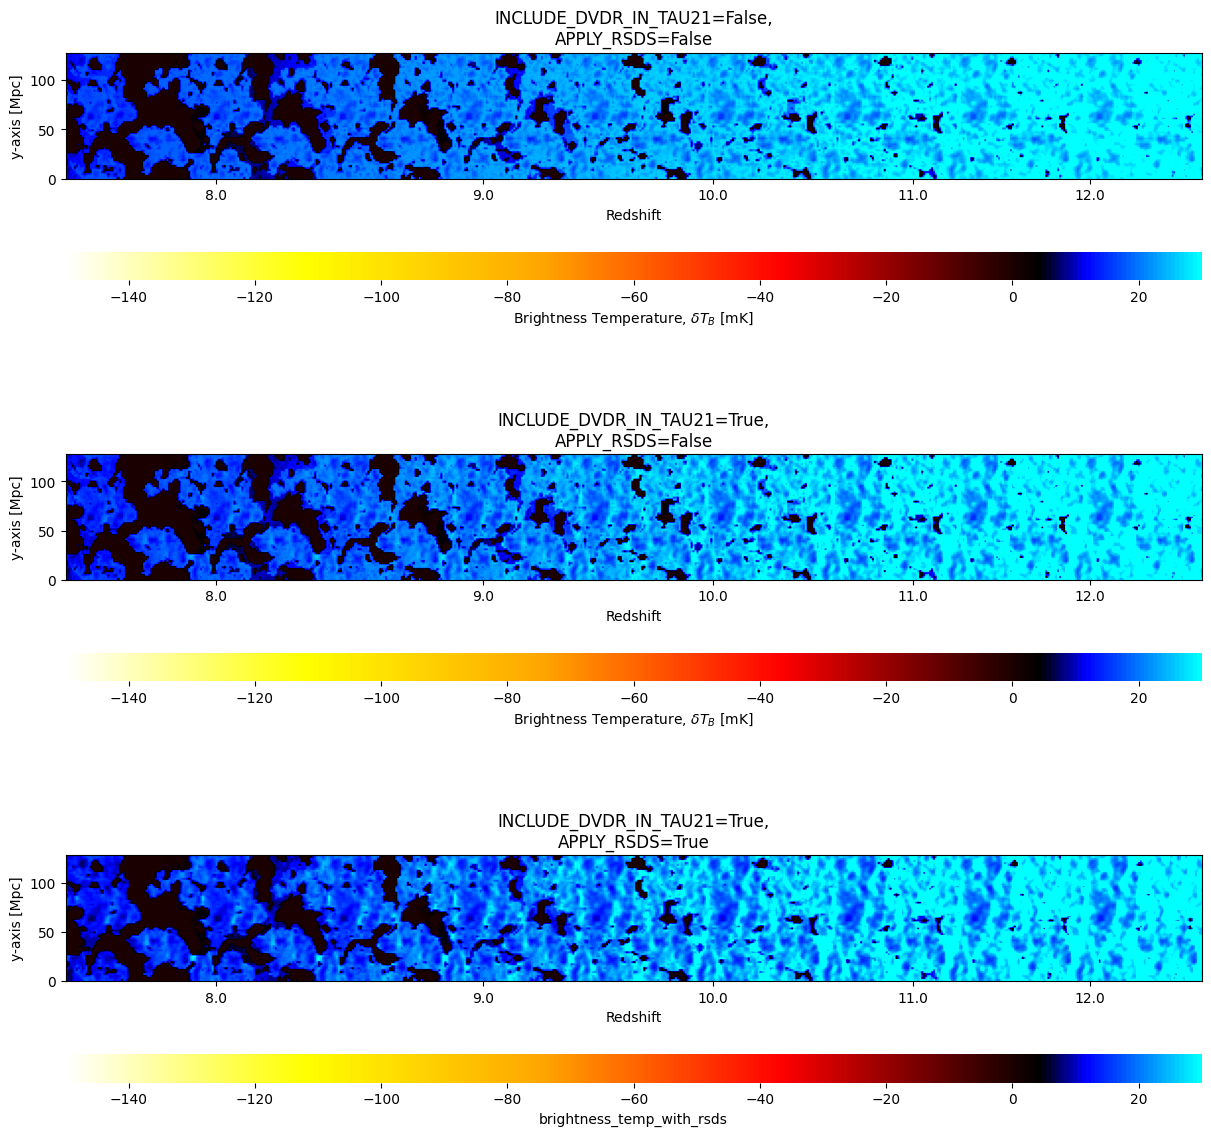

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)
plotting.lightcone_sliceplot(lightcone, kind="brightness_temp", ax=ax[0], fig=fig)
plotting.lightcone_sliceplot(lightcone_include_dvdr_in_tau21, kind="brightness_temp", ax=ax[1], fig=fig)
plotting.lightcone_sliceplot(lightcone_apply_rsds, kind="brightness_temp_with_rsds", ax=ax[2], fig=fig)
ax[0].set_title("INCLUDE_DVDR_IN_TAU21=False,\nAPPLY_RSDS=False")
ax[1].set_title("INCLUDE_DVDR_IN_TAU21=True,\nAPPLY_RSDS=False")
ax[2].set_title("INCLUDE_DVDR_IN_TAU21=True,\nAPPLY_RSDS=True");

Here we see for example, how RSDs make "light blue" regions (with high value of brightness temperature) at $z=12$ to become bluer (i.e. reducing the brightness temperature in these regions).

Interestingly, the effect of RSDs is not as apparent as one would expect at the lowest redshifts, where the peculiar velocities are greater. This is because we were looking on the brightness temperature field which decays once reionization kicks in. However, we could study the effect of RSDs on other fields.
Notice that when `APPLY_RSDS=True`, then for every field we requested in our lightconer, there would be a corresponding one in the output lightcone object which has the ending "_with_rsds". We already so for example that we have in our final lightcone a field with the name ``brightness_temp_with_rsds``. Because in the definition of our lightconer we requested `brightness_temp` and `density` as lightcone quantities, that means we also have `density_with_rsds`!

Below we repeat the same plots as above, but for the density field.

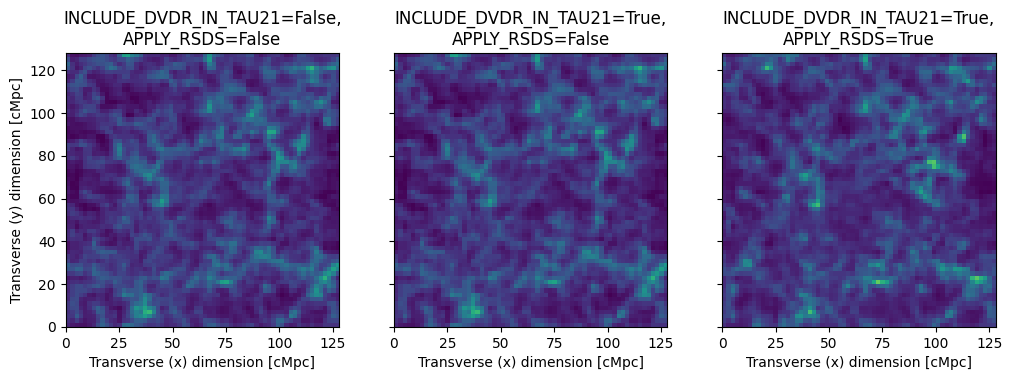

In [11]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 16))
kw_d = {
    "origin": "lower",
    "extent": (0, inputs.simulation_options.BOX_LEN, 0, inputs.simulation_options.BOX_LEN),
    "cmap": "viridis",
    "vmin": -0.5,
    "vmax": 2.5,
}

ax[0].imshow(lightcone.lightcones["density"][:, :, 0], **kw_d)
ax[0].set_title("INCLUDE_DVDR_IN_TAU21=False,\nAPPLY_RSDS=False")
ax[1].imshow(lightcone_include_dvdr_in_tau21.lightcones["density"][:, :, 0], **kw_d)
ax[1].set_title("INCLUDE_DVDR_IN_TAU21=True,\nAPPLY_RSDS=False")
ax[2].imshow(lightcone_apply_rsds.lightcones["density_with_rsds"][:, :, 0], **kw_d)
ax[2].set_title("INCLUDE_DVDR_IN_TAU21=True,\nAPPLY_RSDS=True")

ax[0].set_xlabel("Transverse (x) dimension [cMpc]")
ax[1].set_xlabel("Transverse (x) dimension [cMpc]")
ax[2].set_xlabel("Transverse (x) dimension [cMpc]")
ax[0].set_ylabel("Transverse (y) dimension [cMpc]");

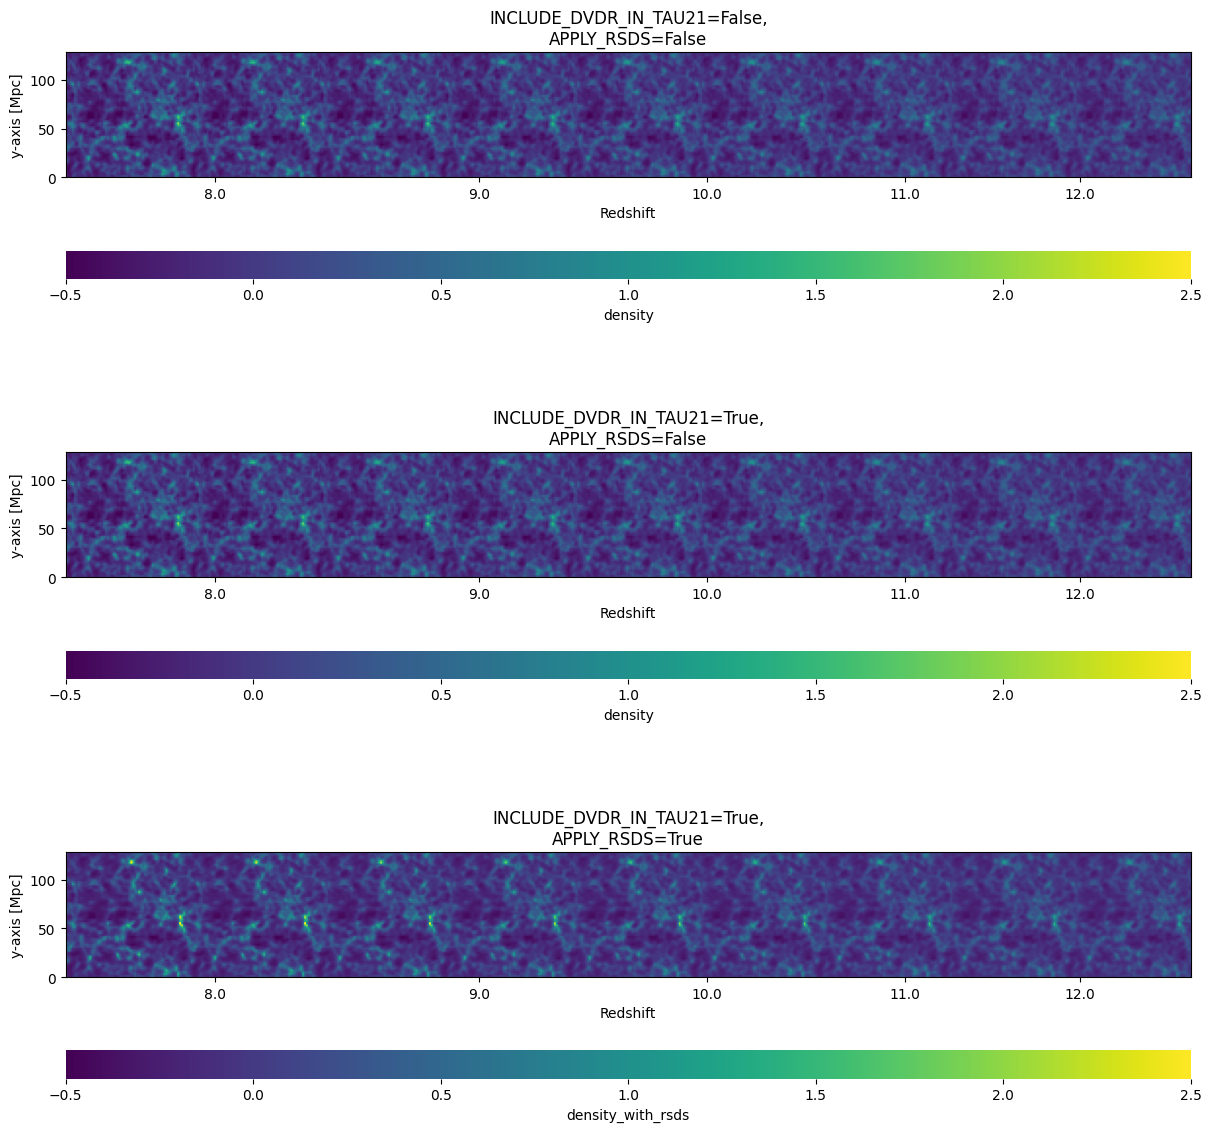

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)
plotting.lightcone_sliceplot(lightcone, kind="density", ax=ax[0], fig=fig, vmin=-0.5, vmax=2.5)
plotting.lightcone_sliceplot(lightcone_include_dvdr_in_tau21, kind="density", ax=ax[1], fig=fig, vmin=-0.5, vmax=2.5)
plotting.lightcone_sliceplot(lightcone_apply_rsds, kind="density_with_rsds", ax=ax[2], fig=fig, vmin=-0.5, vmax=2.5)
ax[0].set_title("INCLUDE_DVDR_IN_TAU21=False,\nAPPLY_RSDS=False")
ax[1].set_title("INCLUDE_DVDR_IN_TAU21=True,\nAPPLY_RSDS=False")
ax[2].set_title("INCLUDE_DVDR_IN_TAU21=True,\nAPPLY_RSDS=True");

As expected, the density field doesn't change in the configuration in which `INCLUDE_DVDR_IN_TAU21=True` and `APPLY_RSDS=False`, because the former flag is relevant only for the brightness temperature field. Furthermore, we indeed see that RSDs matter mostly at low redshifts.

## Redshift Space Distortions in Angular Lightcone

Let us try to run an angular lightcone with the above inputs specifications.

In [13]:
ang_lcn = p21c.AngularLightconer.like_rectilinear(
    simulation_options=inputs.simulation_options,
    match_at_z=inputs.node_redshifts[-1]+0.5,
    max_redshift=inputs.node_redshifts[0]-0.5,
    cosmo=inputs.cosmo_params.cosmo,
    quantities=("brightness_temp","velocity_z")
)

try:
    idx, z, coeval, ang_lightcone_with_rsd = p21c.run_lightcone(
        lightconer=ang_lcn,
        global_quantities=("brightness_temp",),
        inputs=inputs.evolve_input_structs(INCLUDE_DVDR_IN_TAU21=True, APPLY_RSDS=True),
        cache=cache,
        progressbar=True
    )
except ValueError:
    print("ValueError: To account for RSDs or velocity corrections in an angular lightcone, you need to set matter_options.KEEP_3D_VELOCITIES=True")

ValueError: To account for RSDs or velocity corrections in an angular lightcone, you need to set matter_options.KEEP_3D_VELOCITIES=True


This attempt failed because in angular lightcones we cannot simply have one component of the velocity vector (e.g. the $z$ component, $v_z$) in order to account for RSDs, just as we have in rectilinear lightcones. This is because in angular lightcones different LOSs lie on different angles with respect to the observer, and so we must have the 3 components of the velocity vector in order to compute the magnitude of the vector (which points radially out from/into the center of the box).

In order to run angular lightcones with RSDs, we set `KEEP_3D_VELOCITIES=True`.

In [14]:
idx, z, coeval, ang_lightcone_with_rsd = p21c.run_lightcone(
    lightconer=ang_lcn,
    global_quantities=("brightness_temp",),
    inputs=inputs.evolve_input_structs(INCLUDE_DVDR_IN_TAU21=True, APPLY_RSDS=True, KEEP_3D_VELOCITIES=True),
    cache=cache,
    progressbar=True
)

Evolving Astrophysics: 100%|██████████| 7/7 [00:23<00:00,  3.38s/redshift]


The magnitude of the velocity vector (which is not positive by definition, as it can point inward or outward), can be accessed from `los_velocity`. Note this is the same as `velocity_z` in the case of rectilinear lightcone!

In [15]:
print(ang_lightcone_with_rsd.lightcones.keys())

dict_keys(['brightness_temp', 'velocity_z', 'los_velocity', 'brightness_temp_with_rsds', 'velocity_z_with_rsds'])


## Redshift Space Distortions with Coeval Boxes

RSDs are mostly designed to be applied on lightcone boxes in `21cmFASTv4`. However, just as in `21cmFASTv3`, RSDs can also be applied on coeval boxes, as a post process.

Let us run a simple coeval box.

In [16]:
coevals = p21c.run_coeval(
    inputs=inputs.evolve_input_structs(KEEP_3D_VELOCITIES=True),
    out_redshifts=[7,10,12],
    cache=cache,
    regenerate=True,
    progressbar = True
)

Evolving Astrophysics: 100%|██████████| 9/9 [00:04<00:00,  2.02redshift/s]


In order to apply RSDs on the coevals, we use the methods `include_dvdr_in_tau21` and `apply_rsds` which correspond to the same flags we used to account for RSDs in lightcone boxes. It is also possible to call functions of the same names from the `rsd` module of `21cmFAST`.
Calling these methods consecutively is equivalent to calling `apply_velocity_corrections`. A possible argument for these methods is `periodic`, which determines whether the box should be treated with periodic boundary conditions or not. For coeval boxes the default is `True`, while lightcones are considered to be non periodic.

Let us check we understand the logic of these methods.

In [17]:
from py21cmfast.rsds import apply_rsds, include_dvdr_in_tau21

coeval = coevals[0]

# Here we call include_dvdr_in_tau21 and then apply_rsds
box1 = apply_rsds(
    coeval.include_dvdr_in_tau21(),
    los_velocity=coeval.velocity_z,
    redshifts=coeval.redshift,
    inputs=coeval.inputs,
    periodic=True,
    n_subcells=1,
    )
# Here we call apply_rsds and then include_dvdr_in_tau21
box2 = include_dvdr_in_tau21(
    coeval.apply_rsds(n_subcells=1),
    los_velocity=coeval.velocity_z,
    redshifts=coeval.redshift,
    inputs=coeval.inputs,
    periodic=True,
    )
# Here we just call apply_rsds
box3 = coeval.apply_rsds(n_subcells=1)
# Here we just call apply_velocity_corrections
box4 = coeval.apply_velocity_corrections(n_subcells=1)

# Check if the boxes are the same
if np.allclose(box1,box2):
    print("box1 and box2 are the same!")
else:
    print("box1 and box2 are not the same!")
if np.allclose(box3,box4):
    print("box3 and box4 are the same!")
else:
    print("box3 and box4 are not the same!")
if np.allclose(box1,box4):
    print("box1 and box4 are the same!")
else:
    print("box1 and box4 are not the same!")

box1 and box2 are not the same!
box3 and box4 are not the same!
box1 and box4 are the same!


Notice that all these methods can accept an `axis` argument (default is `'z'`), this argument controls which axis should be considered as the LOS axis. If `KEEP_3D_VELOCITIES=True`, we can call these methods for other axes.

In [18]:
box1 = coeval.apply_velocity_corrections(axis='x')
box2 = coeval.apply_velocity_corrections(axis='y')
box3 = coeval.apply_velocity_corrections(axis='z')

# Check if the boxes are the same
if np.allclose(box1,box2):
    print("box1 and box2 are the same!")
else:
    print("box1 and box2 are not the same!")
if np.allclose(box2,box3):
    print("box2 and box3 are the same!")
else:
    print("box2 and box3 are not the same!")
if np.allclose(box1,box3):
    print("box1 and box3 are the same!")
else:
    print("box1 and box3 are not the same!")

box1 and box2 are not the same!
box2 and box3 are not the same!
box1 and box3 are not the same!


This shows that with the same coeval information, we can generate different realizations of the brightness temperature field by simply choosing a different LOS axis!

Let us now `apply_velocity_corrections` on the three coeval boxes we generated from the last run.

In [19]:
boxes_rsd = []
for coeval in coevals:
    box_rsd = coeval.apply_velocity_corrections(n_subcells=1)
    boxes_rsd.append(box_rsd)

Below we plot the surface of the coeval boxes with and without the effect of RSDs.

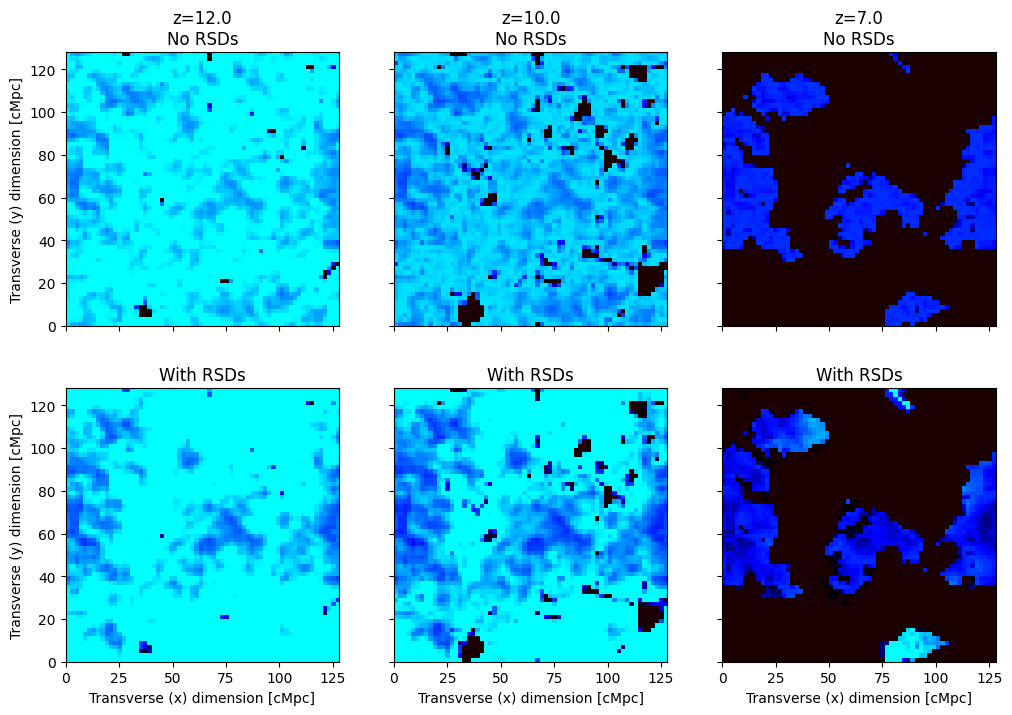

In [20]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))

for ind, (coeval, box_rsd) in enumerate(zip(coevals, boxes_rsd)):
    box = coeval.brightness_temperature.brightness_temp.value
    ax[0,ind].imshow(box[:, :, 0], **kw)
    ax[1,ind].imshow(box_rsd[:, :, 0], **kw)
    ax[0,ind].set_title(f"z={coeval.redshift}\nNo RSDs")
    ax[1,ind].set_title("With RSDs")
    
    ax[1,ind].set_xlabel("Transverse (x) dimension [cMpc]")
ax[0,0].set_ylabel("Transverse (y) dimension [cMpc]")
ax[1,0].set_ylabel("Transverse (y) dimension [cMpc]");

Another parameter that goes into the RSD calculations in coeval boxes is `n_subcells`. This parameter determines into how many subcells each cell  is going to be divided when RSDs are applied: it is the subcells that shift along the LOS, not the cells (unless `n_subcells=1`). Thus, this parameter plays the same role as `N_RSD_STEPS` in `astro_params`, which is relevant only when lightcones are run with `APPLY_RSDS`.

In [21]:
print(f"Default value of N_RSD_STEPS: {inputs.astro_params.N_RSD_STEPS}")

Default value of N_RSD_STEPS: 20


Below we compare how the box at $z=12$ depends on `n_subcells`.

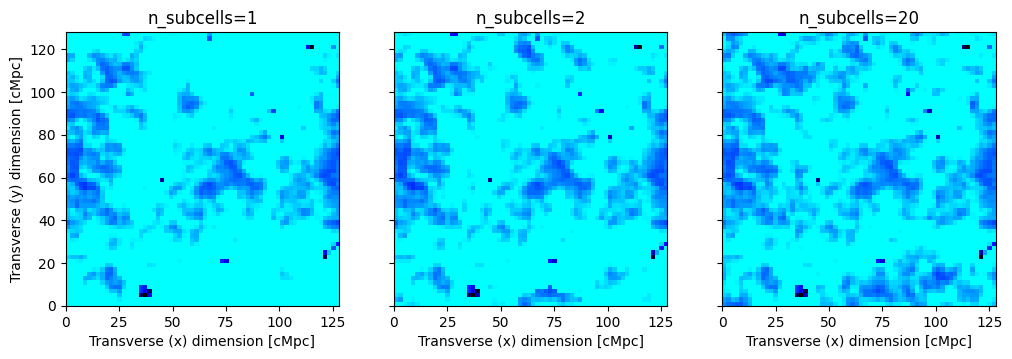

In [22]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))

n_subcells_list = [1,2,20]
for ind, n_subcells in enumerate(n_subcells_list):
    box_rsd = coevals[0].apply_velocity_corrections(n_subcells=n_subcells)
    ax[ind].imshow(box_rsd[:, :, 0], **kw)
    ax[ind].set_title(f"n_subcells={n_subcells}")
    ax[ind].set_xlabel("Transverse (x) dimension [cMpc]")
ax[0].set_ylabel("Transverse (y) dimension [cMpc]");

Just like in the case of lightcones, we can also study the effect of RSDs on any field that is stored in the coeval, not just the brightness temperature. Here, the only relevant method is `apply_rsds`, since `include_dvdr_in_tau21` accounts for an effect that is relevant only for the brightness temperature field. The type of the field to consider can be controlled via the `field` argument (default is `"brightness_temp"`).

Below we compare the effects of RSDs on the density field.

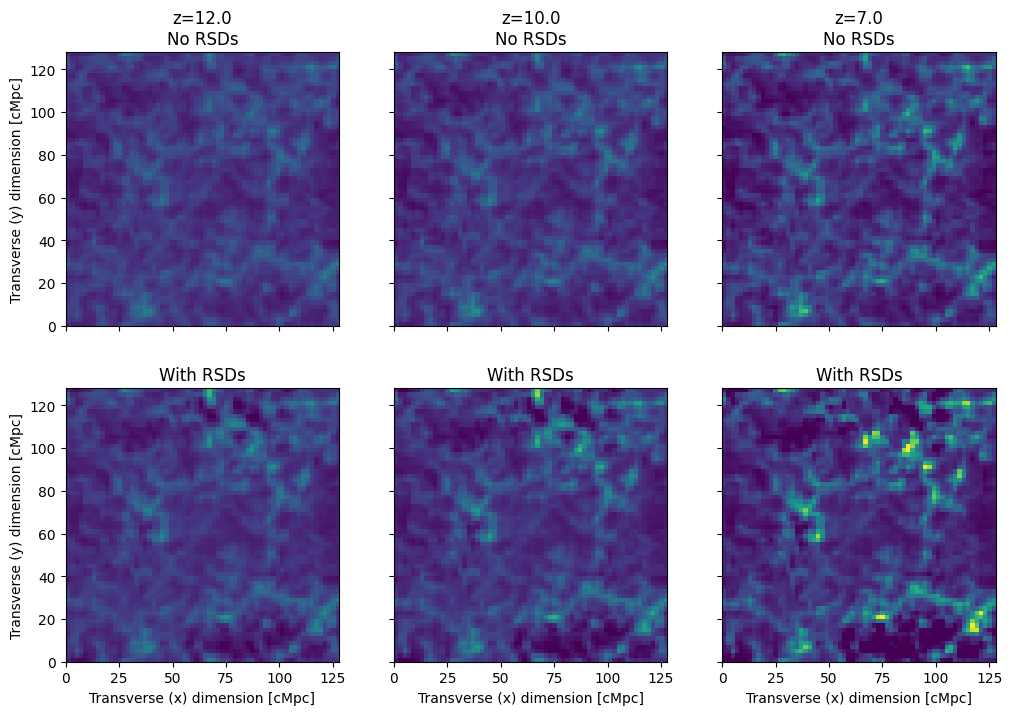

In [23]:
boxes_rsd = []
for coeval in coevals:
    box_rsd = coeval.apply_rsds(field="density",n_subcells=1)
    boxes_rsd.append(box_rsd)

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))

for ind, (coeval, box_rsd) in enumerate(zip(coevals, boxes_rsd)):
    box = coeval.density
    ax[0,ind].imshow(box[:, :, 0], **kw_d)
    ax[1,ind].imshow(box_rsd[:, :, 0], **kw_d)
    ax[0,ind].set_title(f"z={coeval.redshift}\nNo RSDs")
    ax[1,ind].set_title("With RSDs")
    
    ax[1,ind].set_xlabel("Transverse (x) dimension [cMpc]")
ax[0,0].set_ylabel("Transverse (y) dimension [cMpc]")
ax[1,0].set_ylabel("Transverse (y) dimension [cMpc]");

The effect of RSDs is more important at lower redshifts because the peculiar velocities are greater due to gravitational instabilities!

## Redshift Space Distortions, with spin temperature

Previously, we ran the lightcones while setting `USE_TS_FLUCT=False`. This means that the simulation did not evaluate the spin temperature, and instead it used the following simplfied expression for the brightness temperature (see e.g. [Mesinger, Furlanetto and Chen 2010](https://arxiv.org/pdf/1003.3878)),
\begin{equation*}
T_{21}=27\,x_\mathrm{HI}\left(1+\delta\right)\left(\frac{1+z}{10}\frac{0.15}{\Omega_m h^2}\right)^{1/2}\left(\frac{\Omega_b h^2}{0.023}\right)\left|1+\frac{1}{H}\frac{d\left(\mathbf n\cdot \mathbf v\right)}{d\left(\mathbf n\cdot \mathbf x\right)}\right|^{-1}\,\mathrm{mK}.
\end{equation*}

However, when we set `USE_TS_FLUCT=True`, `21cmFAST` computes the brightness temperature according to
\begin{equation*}
T_{21}=\frac{T_s-T_\gamma}{1+z}\left(1-\mathrm{e}^{-\tau_{21}}\right).
\end{equation*}
To understand how both expressions are the same, it is important to realize that when `USE_TS_FLUCT=False`, `21cmFAST` assumes that $\tau_{21}\ll 1$, thereby we can approximate $1-\mathrm{e}^{-\tau_{21}}\approx\tau_{21}$ and assume that $T_{21}\propto\tau_{21}$. This assumption would yield the same equation as above, but with an additional multiplicative factor of $1-T_\gamma/T_s$ (since $\tau_{21}\propto T_s^{-1}$). Thus, in order to get rid of this factor when `USE_TS_FLUCT=False`, `21cmFAST` assumes in addition that $T_s\gg T_\gamma$, an assumption which is valid only at low redshifts, as long as X-ray heating is sufficient enough to heat the gas above the CMB temperature.

Let us suppose now that in some region in space the velocity gradient is so large that $d\left(\mathbf{n}\cdot\mathbf{v}\right)/d\left(\mathbf{n}\cdot\mathbf{x}\right)=-H$. This condition corresponds to a physical scenario in which the peculiar velocity of the gas completely cancels the Hubble flow! As a consequence, the 21cm optical depth diverges in this scenario because the emitted 21cm photon from the atom rest frame is immediately absorbed by a neighbour atom (neglecting their thermal velocities) and the medium is absolutely opaque to 21cm emission. When this happens, the observed brightness temperature (in real space!) is $T_{21}=\left(T_s-T_\gamma\right)/(1+z)$.

However, we see that we get the incorrect result when we use the `USE_TS_FLUCT=False` formula in this scenario (we get $T_{21}=0$). This is expected since the Taylor approximation breaks when $\tau_{21}\to\infty$. In order to deal with this discrepancy, `21cmFAST` clips the velocity gradient field so it won't get too high values when `USE_TS_FLUCT=False`. The clipping threshold is controlled by the parameter `MAX_DVDR`.

In [24]:
print(f"Default value of MAX_DVDR: {inputs.astro_params.MAX_DVDR}")

Default value of MAX_DVDR: 0.2


This means that the optical depth when `USE_TS_FLUCT=False` cannot be modified due to peculiar velocities by more than $|1-0.2|^{-1}=1.25$.

In summary, when `USE_TS_FLUCT=True`, `21cmFAST` **does not** assume that $\tau_{21}\ll1$ and **does not** assume $T_s\gg T_\gamma$. Because of the relaxation of the of the first assumption, we can no longer say that $T_{21}\propto\tau_{21}$. However, since `INCLUDE_DVDR_IN_TAU21=True` modifies the **optical depth** (not the brightness temperature!) with the velocity gradient, we must store $\tau_{21}$ as an additional quantitiy. Let us see that.

In [25]:
inputs = p21c.InputParameters.from_template(
        'simple',
        node_redshifts=p21c.wrapper.inputs.get_logspaced_redshifts(
            min_redshift=7.0,
            z_step_factor=1.02,
            max_redshift=35.0,
        ),
        random_seed=1234,
    ).evolve_input_structs(HII_DIM=64, BOX_LEN=128, N_THREADS = 4)

lcn = p21c.RectilinearLightconer.between_redshifts(
    min_redshift=inputs.node_redshifts[-1]+0.5,
    max_redshift=inputs.node_redshifts[0]-0.5,
    quantities=("brightness_temp",),
    resolution=inputs.simulation_options.cell_size,
)

# We save some coeval boxes at the following redshifts
redshifts = [8,12]
output_redshifts = []
node_redshifts_array = np.array(inputs.node_redshifts)
for redshift in redshifts:
    output_redshift = node_redshifts_array[np.argmin(np.abs(redshift - node_redshifts_array))]
    output_redshifts.append(output_redshift)

gen = p21c.generate_lightcone(
    lightconer=lcn,
    global_quantities=("brightness_temp","tau_21","spin_temperature"),
    inputs=inputs.evolve_input_structs(INCLUDE_DVDR_IN_TAU21=True, APPLY_RSDS=True, USE_TS_FLUCT=True),
    cache=cache,
    progressbar = True,
)

coevals = {}
for iz, redshift, coeval, lightcone_with_Ts in gen:
    if redshift in output_redshifts:
        coevals[redshift] = coeval

Evolving Astrophysics: 100%|██████████| 77/77 [01:54<00:00,  1.49s/redshift]


When both `USE_TS_FLUCT` and `APPLY_RSD` are `True`, coeval boxes contain the 21cm optical depth in `tau_21`. As discussed above, the corresponding lightcone of `tau_21` is the quantitiy that is modified by the velocity gradient, not the brightness temperature.

We plot below the global value of $\tau_{21}$ as a function of redshift.

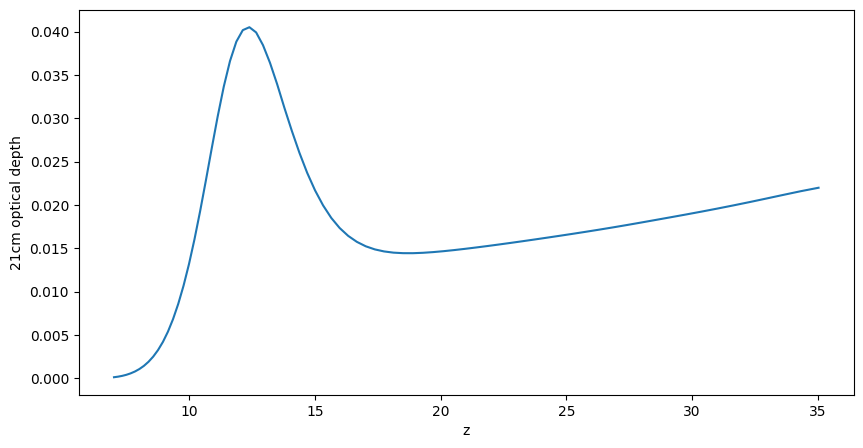

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(inputs.node_redshifts,lightcone_with_Ts.global_quantities["tau_21"])
ax.set_xlabel('z')
ax.set_ylabel('21cm optical depth');

Indeed, $\tau_{21}\ll1$, which is the reason why the common Taylor approximation is justified, as we show below (except for small differences when the spin temperature reaches its minimum value).

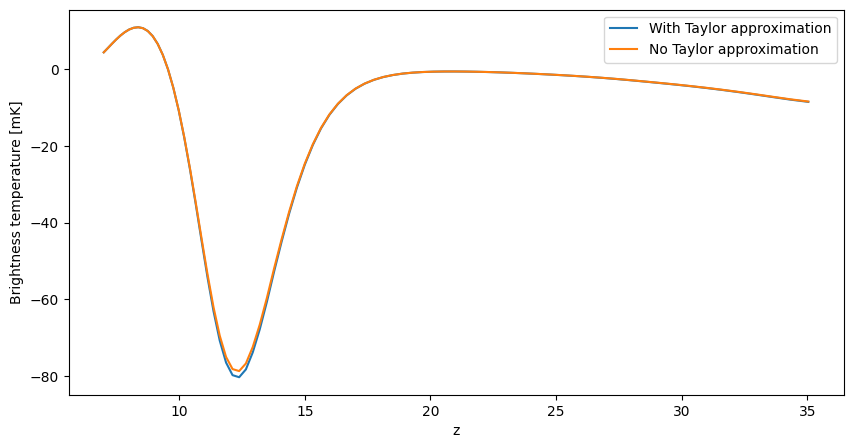

In [27]:
Tcmb0 = 2.7255 # K
redshifts = np.array(inputs.node_redshifts)
T_gamma = Tcmb0 * (1. + redshifts)
T_s = lightcone_with_Ts.global_quantities["spin_temperature"]
tau_21 = lightcone_with_Ts.global_quantities["tau_21"]

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(redshifts,(T_s-T_gamma)/(1.+redshifts)*tau_21*1000,label='With Taylor approximation')
ax.plot(redshifts,(T_s-T_gamma)/(1.+redshifts)*(1. - np.exp(-tau_21))*1000,label='No Taylor approximation')
ax.set_xlabel('z')
ax.set_ylabel('Brightness temperature [mK]')
ax.legend();

Now that we explicitly have the spin temperature, we compare again the lightcones with and without the effects of RSDs.

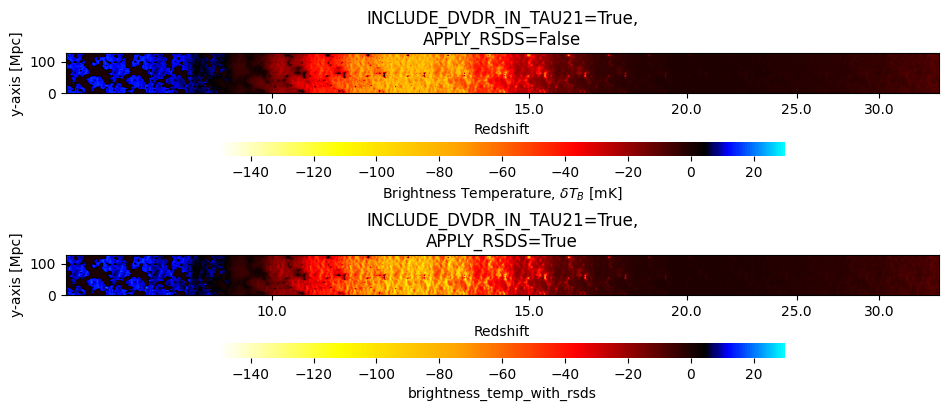

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(12, 4), constrained_layout=True)
plotting.lightcone_sliceplot(lightcone_with_Ts, kind="brightness_temp", ax=ax[0], fig=fig)
plotting.lightcone_sliceplot(lightcone_with_Ts, kind="brightness_temp_with_rsds", ax=ax[1], fig=fig)
ax[0].set_title("INCLUDE_DVDR_IN_TAU21=True,\nAPPLY_RSDS=False")
ax[1].set_title("INCLUDE_DVDR_IN_TAU21=True,\nAPPLY_RSDS=True");

The comparison can be improved if we inspect the coeval boxes instead.

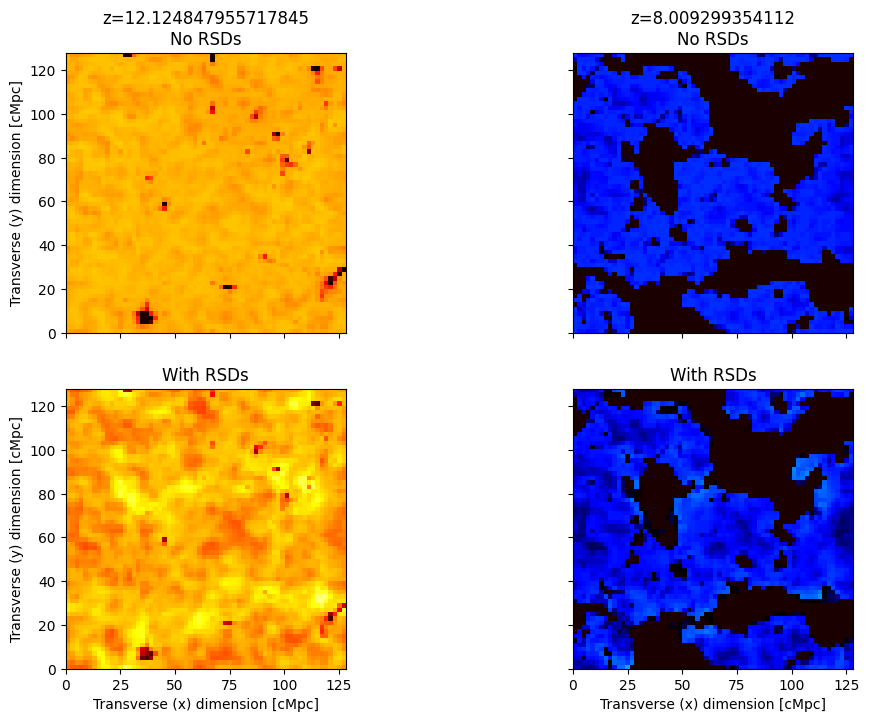

In [29]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))

for ind, redshift in enumerate(coevals.keys()):
    box = coevals[redshift].brightness_temperature.brightness_temp.value
    box_rsd = coevals[redshift].apply_velocity_corrections(periodic=True, n_subcells=20)
    ax[0,ind].imshow(box[:, :, 0], **kw)
    ax[1,ind].imshow(box_rsd[:, :, 0], **kw)
    ax[0,ind].set_title(f"z={redshift}\nNo RSDs")
    ax[1,ind].set_title("With RSDs")
    
    ax[1,ind].set_xlabel("Transverse (x) dimension [cMpc]")
ax[0,0].set_ylabel("Transverse (y) dimension [cMpc]")
ax[1,0].set_ylabel("Transverse (y) dimension [cMpc]");

Now we can see more clearly how RSDs modify the 21cm signal at the minimum of the signal, around $z=12$.